# Gateway

A [Gateway](https://kubernetes.io/docs/concepts/services-networking/gateway/) describes an instance of traffic handling infrastructure. It defines a network endpoint that can be used for processing traffic, i.e. filtering, balancing, splitting, etc. for backends such as a Service. For example, a Gateway may represent a cloud load balancer or an in-cluster proxy server that is configured to accept HTTP traffic.

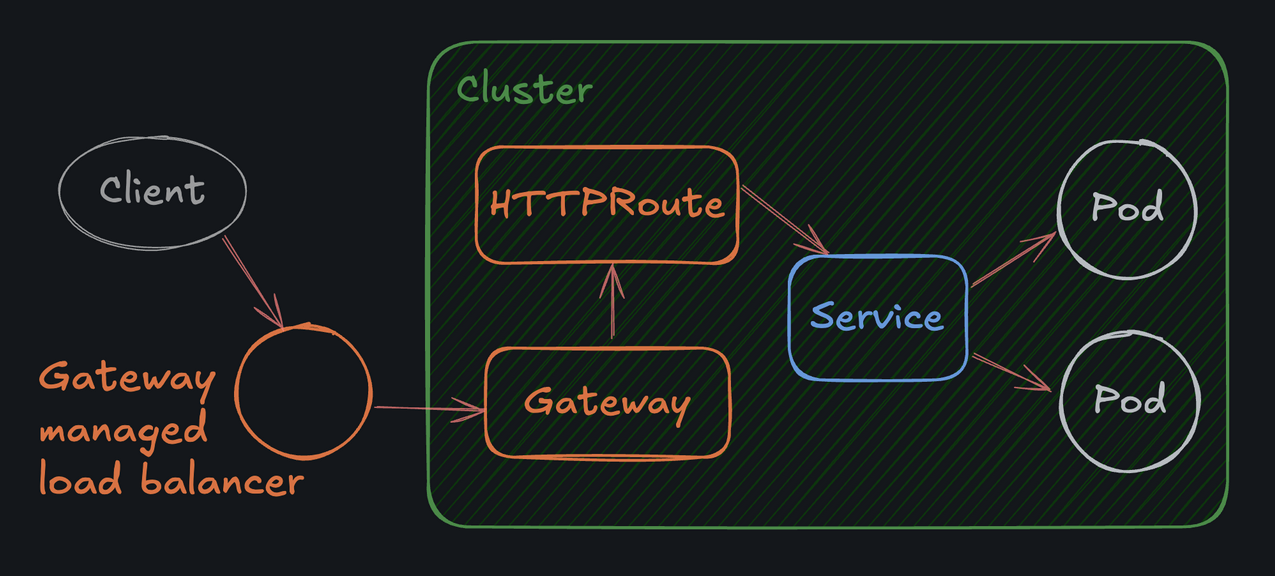

In the diagram above, the "client" can be anything. It doesn't live inside k8s. It might just be a web browser or a mobile app. The "Gateway-managed load balancer" can be a bit confusing, we'll talk about it more later. For now, just know that it's a load balancer that lives outside the cluster and routes traffic through the Gateway to a service.

***Gateway is the newer alternative to [Ingress](https://kubernetes.io/docs/concepts/services-networking/ingress/) which you might still come across in production systems.***

The Gateway API is a `spec` in yaml file that has different implementations. We're gonna use the (Envoy Gateway)[https://gateway.envoyproxy.io/], which you can install with this command:

```python
kubectl apply --server-side -f https://github.com/envoyproxy/gateway/releases/download/v1.5.1/install.yaml
```

Then create `app-gatewayclass.yaml` as the Gateway fpr entire sygnergy chat app not just a specific service:

```yaml
apiVersion: gateway.networking.k8s.io/v1
kind: GatewayClass
metadata:
  name: app-gatewayclass
spec:
  controllerName: gateway.envoyproxy.io/gatewayclass-controller
```

Why we need this GatewayClass:
1. Any Gateway we create has to be associated with a GatewayClass
2. The `controllerName` is set to the one created while installing the Envoy Gateway

Next, create the actual Gateway in new file named `app-gateway.yaml`:

```yaml
apiVersion: gateway.networking.k8s.io/v1
kind: Gateway
metadata:
  name: app-gateway
spec:
  gatewayClassName: app-gatewayclass
  listeners:
    - name: http
      protocol: HTTP
      port: 80
```

Next, we need to define the routing rules for our Gateway with [HTTPRoute resources](https://kubernetes.io/docs/concepts/services-networking/gateway/#api-kind-httproute). Set a rule for the web service, which we could save in a file named `web-httproute.yaml`:

```yaml
apiVersion: gateway.networking.k8s.io/v1
kind: HTTPRoute
metadata:
  name: web-httproute
spec:
  parentRefs:
    - name: app-gateway
  hostnames:
    - "synchat.internal"
  rules:
    - matches:
        - path:
            type: PathPrefix
            value: /
      backendRefs:
        - name: web-service
          port: 80
```

and another for the API service in `api-httproute.yaml`:

```yaml
apiVersion: gateway.networking.k8s.io/v1
kind: HTTPRoute
metadata:
  name: api-httproute
spec:
  parentRefs:
    - name: app-gateway
  hostnames:
    - "synchatapi.internal"
  rules:
    - matches:
        - path:
            type: PathPrefix
            value: /
      backendRefs:
        - name: api-service
          port: 80
```

This says that any traffic to the `synchat.internal` domain name should be routed to the `web-service` and any traffic to `synchatapi.internal` domain name should be routed to the `api-service`.

# DNS

Now that we've configured the Gateway to route the domains:
- `synchat.internal` to the `web-service`
- `synchatapi.internal` to the `api-service`

We need to configure our local machine to resolve those domains to the Gateway load balancer. We won't be setting up global DNS so that anyone on the internet can access our app! We'll just be configuring our local machine to resolve those domains to the Gateway load balancer.

There is a file called `/etc/hosts` on your local machine that is used to resolve domain names to IP addresses. We can add entries to that file to resolve our domains to the Gateway load balancer.

In window, it can be locatedd at `C:\Windows\System32\drivers\etc\hosts`

Open it with any text editor and add the following line:

```
127.0.0.1        synchat.internal
127.0.0.1        synchatapi.internal
```

Now both `synchat.internal` and `synchatapi.internal` should resolve to the IP address `127.0.0.1` (which is just localhost).

To make sure it's working, run:

```python
ping synchat.internal
```

and

```python
ping synchatapi.internal
```

You should see something like:

```
PING synchat.internal (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.025 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=0.043 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=0.038 ms
64 bytes from localhost (127.0.0.1): icmp_seq=4 ttl=64 time=0.051 ms
64 bytes from localhost (127.0.0.1): icmp_seq=5 ttl=64 time=0.024 ms
64 bytes from localhost (127.0.0.1): icmp_seq=6 ttl=64 time=0.028 ms
...
```

Which is good (see the response time), you can kill it with `ctrl+c`

# Tunnel

In production, once you have a Gateway configured and have pointed your domain name to it (and perhaps its load balancer), you can access your application from anywhere in the world. The trouble is, we're using Minikube (as we discuss before) and the cluster is running on our local machine, and not only that, it's running in an isolated virtual machine.

Fear not! Minikube has a command that will forward the Gateway to your local machine.

Open a tunnel to your cluster with this command:

```python
minikube tunnel -c
```

*I recommend you keep it open in a separate terminal window and work on another*

The tunnel should expose the Gateway controller's load balancer to your local machine on `127.0.0.1:80`, which we mapped to the `synchat.internal` and `synchatapi.internal` domains in the previous exercise.

The Correct running flow for all what we do will be:

DNS (/etc/hosts) -> IP address -> Gateway -> Http Route -> Service -> Pod

# Gateway Types

You may have noticed that at the top of all our resources we have this in the YAML:

```yaml
apiVersion: v1
```

This is the API version of the resource, and because those resources are core to Kubernetes, they're in the standard `v1` API group.

However, Gateway isn't a core Kubernetes resource, it's an extension of sorts. That's why it has:

```yaml
apiVersion: gateway.networking.k8s.io/v1
```

You can think of the `networking.k8s.io` API group as a core extension. It's not third-party, but it's not part of the core Kubernetes API either.

The core Kubernetes API is intentionally kept small, but there are a lot of things that people want to do with Kubernetes that aren't part of the core API. So, instead of adding a bunch of new fields to the core API, Kubernetes allows you to add arbitrary annotations to your resources, and then various extensions can read those annotations and do things with them.

# Chat

Now that everything is accessible via Gateway (at least while the tunnel is open), let's connect the web application front-end to the API.

Create a new ConfigMap for the web service. Add two new environment variables:
- `WEB_PORT: "8080"` (this was already the default, now we're just making it explicit)
- `API_URL: "http://synchatapi.internal"`

Update the web application's deployment to use the new ConfigMap.

Once all that's applied to your cluster, you should be able to open the web application and actually use the chat interface (notice it's "synchat", not "synchatapi"):

```
http://synchat.internal
```

Make sure that you can enter a username and a message, and send a message as that user! Assuming it works, that's because the webpage is now sending messages via fetch requests to the api service. The api service saves those messages locally in memory.

To see what I mean, try the following:
- Create a few messages as different users.
- Refresh the page
- The messages should still be there because they're saved in the server's memory.
- Now, delete the api pod
- Once k8s replaces the deleted pod with a new one, refresh the page again.